In [1]:
from tools import *


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

set_plot_style()

# Introdução

O alto índice de faltas em agendamentos (no-shows) é um problema recorrente em salões de beleza, pois gera ociosidade de profissionais, perda de receita e aumento do tempo de espera para outros clientes. A identificação antecipada de clientes com maior probabilidade de não comparecimento permite que o salão adote estratégias preventivas, como solicitação de depósito antecipado, envio de lembretes personalizados ou realocação inteligente de horários.

Utilizamos dados históricos de agendamentos para analisar padrões de comportamento e desenvolver um modelo preditivo capaz de estimar a probabilidade de no-show, apoiando decisões operacionais e melhorando a eficiência do serviço.

# Objetivo do Projeto

Este projeto tem como objetivo desenvolver uma solução baseada em dados e estatística para prever a probabilidade de um cliente não comparecer ao seu agendamento (no-show), buscando identificar padrões comportamentais e fatores relevantes associados às faltas, permitindo que o salão tome decisões operacionais de forma mais assertiva.
Como resultado, pretende-se criar uma ferramenta analítica que auxilie o salão a reduzir perdas financeiras por meio do aumento da taxa de ocupação dos profissionais e melhor a experiência dos clientes.

## Dataset



In [2]:
df_hair_salon = pd.read_csv('../data\hair_salon_no_show_wrangled_df.csv')
df_hair_salon.head()


,Unnamed: 0,book_tod,book_dow,book_category,book_staff,last_category,last_staff,last_day_services,last_receipt_tot,last_dow,...,last_prod_flag,last_cumrev,last_cumbook,last_cumstyle,last_cumcolor,last_cumprod,last_cumcancel,last_cumnoshow,noshow,recency
0,0,afternoon,Wednesday,STYLE,JJ,NaN,NaN,0,0.0,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1,morning,Wednesday,COLOR,JOANNE,NaN,NaN,0,0.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2,NaN,Wednesday,STYLE,JJ,COLOR,JOANNE,2,262.0,Wednesday,...,1,262,2,1,1,2,0,0,0,35
3,3,afternoon,Thursday,STYLE,KELLY,NaN,NaN,0,0.0,NaN,...,0,0,0,0,0,0,0,0,0,0
4,4,evening,Saturday,STYLE,KELLY,STYLE,KELLY,1,35.0,Thursday,...,0,35,1,1,0,0,0,0,0,9


In [3]:
df_hair_salon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1952 entries, 0 to 1951
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1952 non-null   int64  
 1   book_tod           1717 non-null   object 
 2   book_dow           1952 non-null   object 
 3   book_category      1952 non-null   object 
 4   book_staff         1952 non-null   object 
 5   last_category      1003 non-null   object 
 6   last_staff         1003 non-null   object 
 7   last_day_services  1952 non-null   int64  
 8   last_receipt_tot   1952 non-null   float64
 9   last_dow           1003 non-null   object 
 10  last_tod           858 non-null    object 
 11  last_noshow        1952 non-null   int64  
 12  last_prod_flag     1952 non-null   int64  
 13  last_cumrev        1952 non-null   int64  
 14  last_cumbook       1952 non-null   int64  
 15  last_cumstyle      1952 non-null   int64  
 16  last_cumcolor      1952 

## Qual é a taxa geral de no-show no dataset? (Percentual de clientes que não compareceram ao agendamento versus os que compareceram)

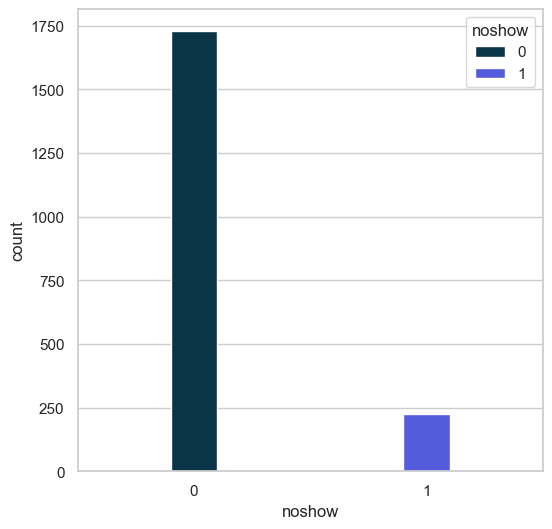

Revelando um dataset desbalanceado, onde 1 cancelamento a cada: 7.71  agendamentos. O no-show representa apenas 0.11%


In [ ]:
plt.figure(figsize=(6,6))
sns.countplot(data=df_hair_salon, x='noshow',  hue='noshow', legend=True, width= 0.2)
plt.show()

proportion_noshow = df_hair_salon['noshow'].value_counts(normalize=False)
proportion_noshow_percent = proportion_noshow[1] / df_hair_salon['noshow'].count()
proportion_noshow = round(proportion_noshow[0] / proportion_noshow[1], 2)


print(f'Revelando um dataset desbalanceado, onde 1 cancelamento a cada: {proportion_noshow}  agendamentos. O no-show representa apenas {round(proportion_noshow_percent, 2)}% dos dados totais')

## Existem padrões sazonais de no-show (por dia da semana, mês ou estação do ano)?

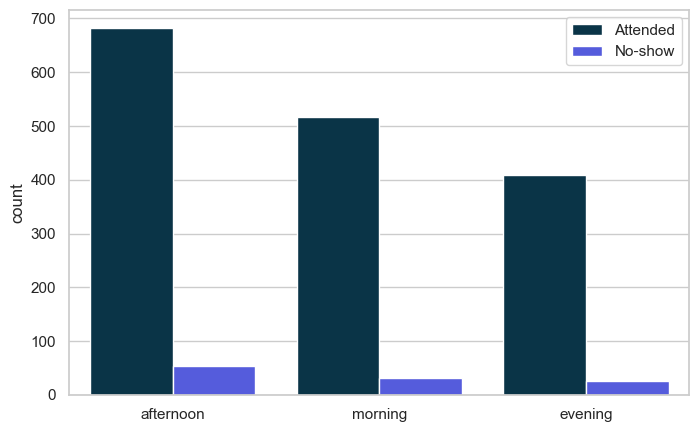

In [ ]:
plt.figure(figsize=(8,5))
ax = sns.countplot(data=df_hair_salon, x='book_tod',  hue='noshow')
ax.legend( labels=['Attended', 'No-show'])
plt.xlabel('')
plt.show()

Como a quantidade de agendamentos é diferente durante os periodos dos dias, para uma melhor comparação é melhor olha a razao agendamentos/cancelamentos

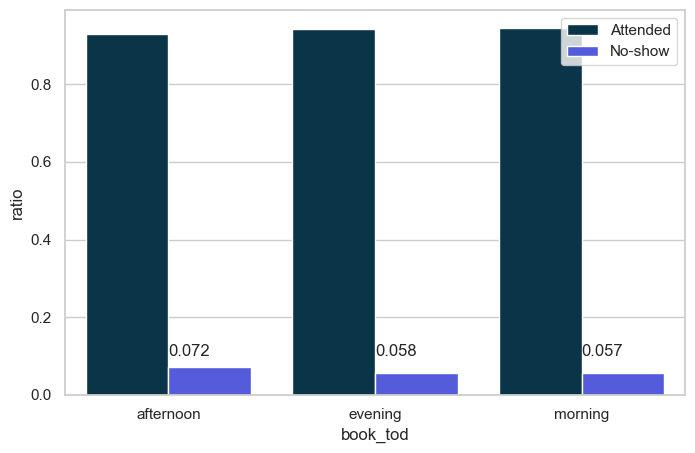

In [ ]:
rate_df = (
    df_hair_salon
    .groupby('book_tod')['noshow']
    .value_counts(normalize=True)
    .rename('ratio')
    .reset_index()

    
)

plt.figure(figsize=(8,5))
ax = sns.barplot(data=rate_df, x='book_tod', y = 'ratio',  hue='noshow')
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles,
          labels=['Attended', 'No-show'])

plt.text(0, 0.1, round(rate_df['ratio'][1], 3))
plt.text(1, 0.1, round(rate_df['ratio'][3], 3))
plt.text(2, 0.1, round(rate_df['ratio'][5], 3))

plt.show()

Podemos ser mais expecificos tbm e olhar para os horios mais escolhidos durante os dias. Pra esse dados, vamos ignorar os minutos para uma melhor entendimento e visualizacao dos dados


In [ ]:
df_Future_book = pd.read_csv('../data\Future Bookings (All Clients)0.csv')
df_Future_book['Time'] = pd.to_datetime(df_Future_book['Time'],  format='%I:%M:%S %p').dt.strftime('%H')
df_Future_book.head()

,Code,Staff,Service,Date,Time,TimeInt
0,JUNJ01,JJ,CON,03/14/2018,15,950
1,NORJ01,JJ,SHCM,03/14/2018,16,960
2,CORS01,JJ,SHCW,03/15/2018,14,850
3,KERT01,JJ,SHCW,03/15/2018,10,600
4,LEHJ01,JJ,SHCM,03/15/2018,18,1080


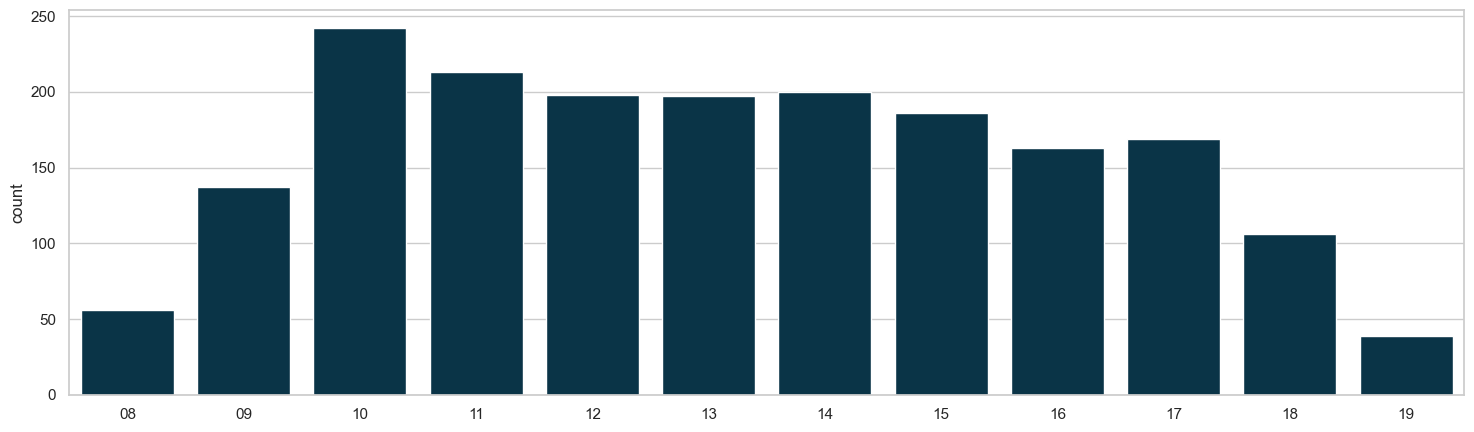

In [ ]:
plt.figure(figsize=(18,5))
ax = sns.countplot(data=df_Future_book.sort_values(by = 'Time'), x='Time')
plt.xlabel('')
plt.show()

Revelando que taxa de cancelamento independendo do periodo tem taxas bem parecidas.  Porem podemos se perguntar se o dia da semana é relevante.

Text(0.5, 0, '')

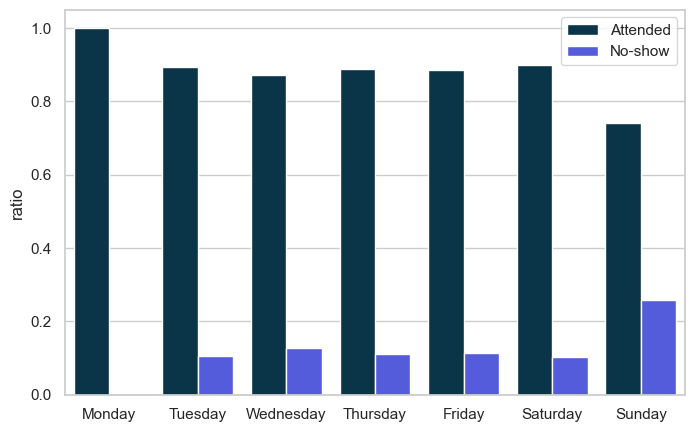

In [ ]:
rate_df = (
    df_hair_salon
    .groupby('book_dow')['noshow']
    .value_counts(normalize=True)
    .rename('ratio')
    .reset_index()

    
)
order_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
              'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(8,5))
ax = sns.barplot(data=rate_df, x='book_dow', y = 'ratio',  hue='noshow', order=order_days)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=handles,
          labels=['Attended', 'No-show'])
ax.set_xlabel('')


Novamente olhando para a razção no lugar do valor absoluto, encontramos algo interesante. As segundas feiras nao a registro de cancelamento, porem aos sabados, é possivel observar que o valor mais q dobra quando comparados com os outros dias.

## Clientes que marcaram com maior antecedência (maior intervalo entre agendamento e data do atendimento) têm maior probabilidade de faltar?

In [ ]:
df_client_cancel = pd.read_csv('../data\Client Cancellations0.csv')
df_client_cancel.head()

,Cancel Date,Code,Service,Staff,Booking Date,Canceled By,Days
0,05/22/2018,MASA01,CFC,JOANNE,05/24/2018,ADMIN,2.0
1,06/27/2018,MASA01,CBAL,KELLY,06/27/2018,ADMIN,0.0
2,07/03/2018,MASA01,SHCM,BECKY,07/10/2018,BECKY,7.0
3,07/10/2018,MASA01,SHCC,JJ,07/11/2018,KELLY,1.0
4,07/24/2018,TRUA01,SHCM,KELLY,07/24/2018,TANYA,0.0


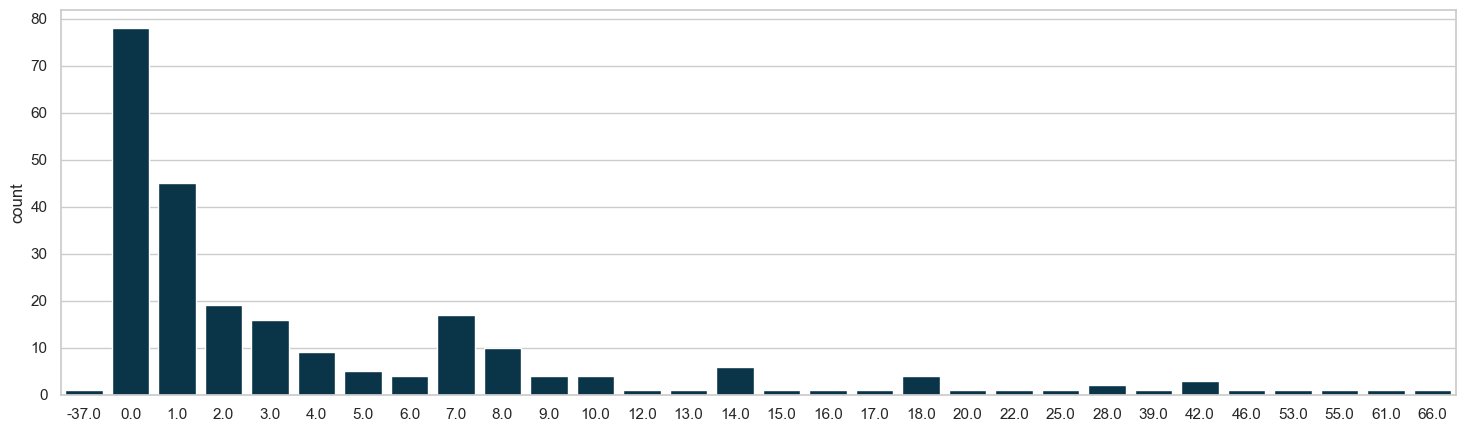

In [ ]:
plt.figure(figsize=(18,5))
ax = sns.countplot(data=df_client_cancel.sort_values(by = 'Days'), x='Days')
plt.xlabel('')
plt.show()

esse grafico mostra um alta quantidade de cancelamentos realizado em cima da hora, isto é, no msm dia do agendamento. Os valores començam a diminuier ate mudar no perido de 1 semana. Esse resultado mostrar que a atenção deve ser voltado a agendamentos em ate 1 semana.